In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


**1. Import Libraries & Load Dataset**

In [74]:
# 📦 Importing Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')


**2.Load Dataset**

In [75]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/train.csv", encoding='latin1')
test = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/test.csv", encoding='latin1')

In [76]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [77]:
#concat training and testing dataset
df = pd.concat([df,test])

In [78]:
df.shape

(32296, 10)

In [79]:
#check unique values of sentiment column 
df['sentiment'].value_counts()

sentiment
neutral     12548
positive     9685
negative     8782
Name: count, dtype: int64

In [80]:
#drop uncessary columns 
df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)', "selected_text"], axis=1, inplace=True)

In [81]:
df.isnull().sum()

text         1282
sentiment    1281
dtype: int64

In [82]:
df.dropna(inplace=True)

In [83]:
df.duplicated().sum()

0

**3.Data Preprocessing**

In [84]:
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', str(raw_text))
    return cleaned_text

In [85]:
#remove tags and making everything in lower case
df['cleaned_text'] = df['text'].apply(remove_tags)
df['cleaned_text'] = df['text'].apply(lambda x:str(x).lower())
def remove_unnecessary_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text
df['cleaned_text'] = df['text'].apply(remove_unnecessary_characters)    

**4.Normalize**

In [86]:
def normalize_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text
df['cleaned_text'] = df['text'].apply(normalize_text)

In [87]:
#remove stepwords and url
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
sw_list = stopwords.words('english')

df['cleaned_text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))
def remove_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    pattern = re.compile(r'http?://\S+|www\.\S+')
    return pattern.sub(r'', text)
df['cleaned_text'] = df['text'].apply(remove_urls)    

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
df.head()

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",neutral,"I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!,negative,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...,negative,my boss is bullying me...
3,what interview! leave me alone,negative,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t...",negative,"Sons of ****, why couldn`t they put them on t..."


In [89]:
exclude = string.punctuation
exclude

def remove_punc1(text):
    return text.translate(str.maketrans('', '', exclude))
df['cleaned_text'] = df['text'].apply(remove_punc1)


**5.Splitting Dataset**

In [90]:
X = df['cleaned_text']
y = df['sentiment']

**6.Encoding Categorical Variable**

In [91]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y = encoder.fit_transform(y)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()

In [92]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train_bow,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1)

In [93]:
y_pred = lr.predict(X_test_bow)
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
score_lr = accuracy_score(y_test, y_pred)
score_lr

0.6907947767209415

**7.Model evaluation**

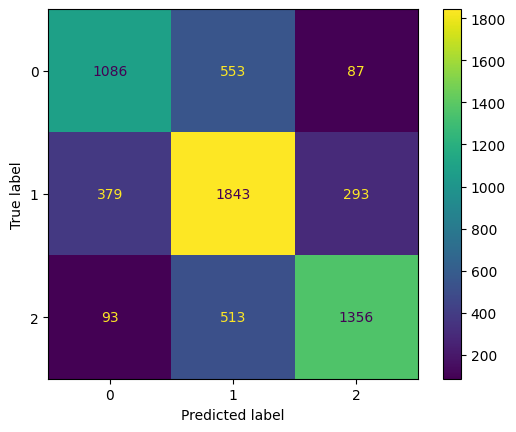

In [94]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [95]:
# Save model
joblib.dump(model, 'sentinal_model.pkl')

['sentinal_model.pkl']

In [99]:
import joblib

# Save both vectorizer and model as a tuple
joblib.dump((cv, lr), '/kaggle/working/sentinal_model.pkl')


['/kaggle/working/sentinal_model.pkl']

**8.API Creation**

In [ ]:
from flask import Flask, request, jsonify, render_template_string
import joblib

# Create Flask app
app = Flask(__name__)

# Load model and vectorizer tuple
cv, lr = joblib.load("sentinal_model.pkl")

# Inline HTML for testing form interface (can be previewed in notebooks with render_template_string)
template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Sentiment Analysis</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f2f2f2;
            text-align: center;
            padding-top: 50px;
        }
        form {
            background-color: white;
            display: inline-block;
            padding: 30px;
            border-radius: 8px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }
        input[type=text] {
            width: 300px;
            padding: 10px;
            margin-top: 10px;
            margin-bottom: 20px;
        }
        input[type=submit] {
            padding: 10px 20px;
            background-color: #007BFF;
            color: white;
            border: none;
            border-radius: 5px;
            cursor: pointer;
        }
        h2 {
            margin-top: 30px;
        }
    </style>
</head>
<body>
    <h1>Sentiment Analysis</h1>
    <form action="/" method="POST">
        <input type="text" name="user_input" placeholder="Enter your sentence..." required>
        <br>
        <input type="submit" value="Predict Sentiment">
    </form>
    {% if prediction %}
        <h2>Prediction: {{ prediction }}</h2>
    {% endif %}
</body>
</html>
'''

@app.route("/", methods=["GET", "POST"])
def predict_sentiment():
    prediction = None
    if request.method == "POST":
        text = request.form["user_input"]
        features = cv.transform([text])
        prediction = lr.predict(features)[0]
    return render_template_string(template, prediction=prediction)

@app.route("/api/predict", methods=["POST"])
def api_predict():
    data = request.get_json()
    if not data or "text" not in data:
        return jsonify({"error": "Missing 'text' in request"}), 400

    features = cv.transform([data["text"]])
    prediction = lr.predict(features)[0]
    return jsonify({"prediction": prediction})
if __name__ == "__main__":
    app.run(debug=True)


In [104]:
# Example test prediction directly in notebook
sample_text = "I really love this product!"
features = cv.transform([sample_text])
prediction = lr.predict(features)[0]
print("Prediction:", prediction)


Prediction: 2
